# Setup

## Imports and definitions

No secular terms, only resonant

In [1]:
from matplotlib import pyplot as plt
%matplotlib widget
import sys
sys.path.append("/Users/jtlaune/Notes/notes/code_notebooks/")
from mpl_styles import analytic
plt.style.use(analytic)

In [2]:
import os
import sympy as sm
import scipy as sp
import numpy as np
from scipy.special import hyp2f1
import matplotlib as mpl
import matplotlib.ticker as ticker
from sympy import init_printing, init_session
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return -0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return -0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))


def sqr_ei_lc(alpha):
    """
    MD p275
    f3lc x [e1^2 + e2^2]
    (1/8)[2α_12 D + α_12^2 D^2]b_{1/2}^(0)
    """
    return 0.25 * alpha * Db(0.5, 0, alpha) + alpha**2 / 8 * 0.5 * (
        Db(1.5, 1, alpha)
        - 2 * alpha * Db(1.5, 0, alpha)
        + Db(1.5, 1, alpha)
        - 2 * b(1.5, 0, alpha)
    )


def eiej_lc(alpha):
    """
    MD p275
    f4lc x [e1e2]
    (1/4)[2 − 2α_12 D − α_12^2 D^2]b_{1/2}(1)
    """
    # These are the values given in Murray Dermott.
    # signs on C and D are to be consistent with Laetitia's notes
    # fs1
    return (
        0.5 * b(0.5, 1, alpha)
        - 0.5 * alpha * Db(0.5, 1.0, alpha)
        - 0.25
        * alpha**2
        * 0.5
        * (
            Db(1.5, 0, alpha)
            - 2 * alpha * Db(1.5, 1, alpha)
            + Db(1.5, 2, alpha)
            - 2 * b(1.5, 1, alpha)
        )
    )


IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [3]:
alpha0 = (2 / (2 + 1)) ** (2.0 / 3)
f1val = f27lc(alpha0, 2)
f2val = f31lc(alpha0, 2)

## Hamiltonian

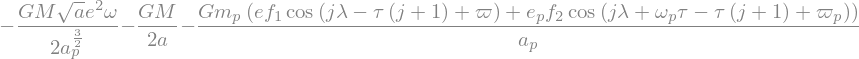

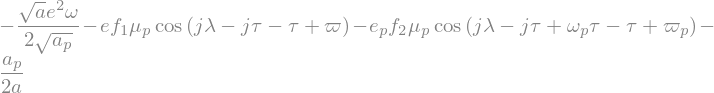

In [4]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f1 * sm.cos((j + 1) * tau - j * l - pom)
        + e_p * f2 * sm.cos((j + 1) * tau - j * l - pom_p - om_p * tau)
    )
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (calH / H_scale_factor).subs(m_p, mu_p * M).simplify().expand()
display(calH)


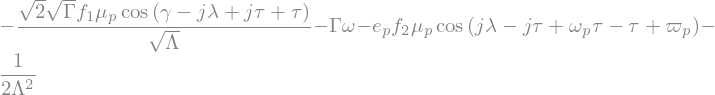

In [5]:
L_a = sqrt(Gconst*M*a)/L_scale_factor
G_eL = Rational(1, 2) * L * e**2
G_ea = G_eL.subs(L, L_a)
a_L = solve(L_a - L, a)[0]
e_GL = solve(G_eL - G, e)[0]
display(L_scale_factor)

calH_canon = calH.subs(a,a_L).subs(e,e_GL).subs(pom,-g)
display(calH_canon)

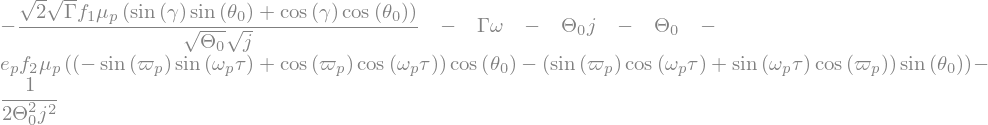

In [6]:
th0, Th0 = sm.symbols(r"theta_0 Theta_0")
F1 = -Th0 * ((j + 1) * tau - j * l)
F1
L_F1 = sm.diff(F1, l)
Th0_F1 = sm.solve(sm.diff(F1, l) - L, Th0)[0]
l_F1 = sm.solve(sm.diff(F1, Th0) - th0, l)[0]
th0_F1 = sm.diff(F1, Th0)

# canonical transform with generating function F
calH0 = sm.expand_trig((calH_canon + sm.diff(F1, tau)).subs(L, L_F1).subs(l, l_F1).simplify())
display(calH0)

In [7]:
X_Gg = sqrt(2*G)*cos(g)
Y_Gg = -sqrt(2*G)*sin(g)
G_xy = Rational(1,2)*(X**2+Y**2)
g_xy = -atan2(Y,X)
display(simplify(X_Gg.subs(G,G_xy).subs(g,g_xy)))
display(simplify(Y_Gg.subs(G,G_xy).subs(g,g_xy)))

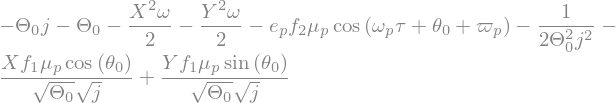

In [8]:
calH_thXY = calH0.subs(G,G_xy).subs(g,g_xy).simplify(deep=True)
display(calH_thXY)

Note that here, $\theta_0=-\theta_1$ (in the analytic section) because of the signs on $\varpi_p$.

## Equations of motion

In [9]:
th0_res_dot = sm.diff(calH_thXY, Th0).simplify()
Th0_res_dot = -sm.diff(calH_thXY, th0).simplify()
X_res_dot   = sm.diff(calH_thXY, Y).simplify()
Y_res_dot   = -sm.diff(calH_thXY, X).simplify()

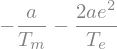

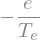

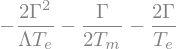

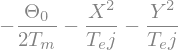

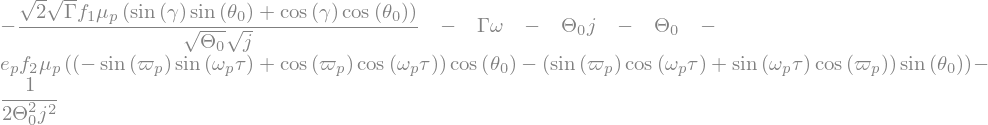

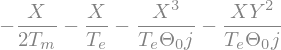

In [10]:
adot_ae = expand(a * (-1 / Tm - 2 * e**2 / Te))
edot_e = -e / Te

Ldot_dis = expand(cancel((diff(L_a, a) * adot_ae))).subs(e,e_GL).subs(a,a_L).simplify()
Gdot_dis = (diff(G_ea,e)*edot_e + diff(G_eL,L)*Ldot_dis).subs(e,e_GL).subs(a,a_L).simplify()
Th0dot_dis = (diff(Th0_F1,L)*Ldot_dis).subs(G,(X**2+Y**2)/2).subs(L,L_F1).simplify()
Xdot_dis   = ((diff(X_Gg,G)*Gdot_dis+diff(X_Gg.subs(G,G_eL),L)*Ldot_dis).subs(e,e_GL).subs(g,g_xy).subs(G,G_xy).subs(L,L_F1)).cancel().expand()
Ydot_dis   = ((diff(Y_Gg,G)*Gdot_dis+diff(Y_Gg.subs(G,G_eL),L)*Ldot_dis).subs(e,e_GL).subs(g,g_xy).subs(G,G_xy).subs(L,L_F1)).cancel().expand()

display(adot_ae,edot_e)
display(Gdot_dis)
display(Th0dot_dis)
display(calH0)
display(Xdot_dis)

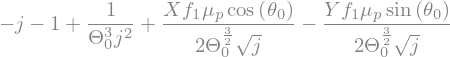

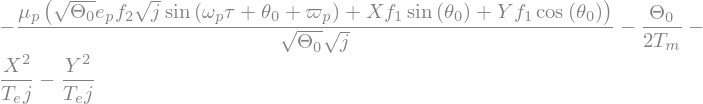

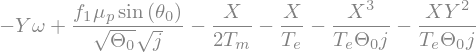

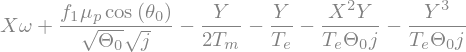

In [11]:
th0_dot = th0_res_dot
Th0_dot = Th0_res_dot + Th0dot_dis
X_dot = X_res_dot + Xdot_dis
Y_dot = Y_res_dot + Ydot_dis
display(th0_dot)
display(Th0_dot)
display(X_dot)
display(Y_dot)

## Integration RHS

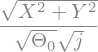

In [12]:
th0_canon = th0
a_canon   = solve(Th0-Th0_F1.subs(L,L_a), a)[0]
e_canon   = e_GL.subs(G,G_xy).subs(L,L_F1).simplify()
pom_canon = -g_xy
display(th0_canon)
display(a_canon)
display(e_canon)
display(pom_canon)

In [13]:
th0_orbelts = th0_F1
Th0_orbelts = Th0_F1.subs(L,L_a)
X_orbelts = X_Gg.subs(G,G_ea).subs(g,-pom)
Y_orbelts = Y_Gg.subs(G,G_ea).subs(g,-pom)

In [14]:
th0_F1

In [143]:
def plug_in_parameters(expr, omval, om_pval, epval, mupval, Teval, Tmval):
    alpha0 = (2 / (2 + 1)) ** (2.0 / 3)
    # comment out to get the expressions unevaluate
    expr = (
        expr.subs(f1, f27lc(alpha0, 2))
        .subs(f2, f31lc(alpha0, 2))
        .subs(f3,0)
        .subs(f4,0)
        .subs(mu_p, mupval)
        .subs(e_p, epval)
        .subs(j, 2)
        .subs(Te, Teval)
        .subs(Tm, Tmval)
        .subs(a_p, 1.0)
        .subs(pom_p, 0.0)
        .subs(om, omval)
        .subs(om_p, om_pval)
        .subs(tau, t)
    )
    return expr


@mpl.rc_context(analytic)
def plot(sol, th0_int, a_int, e_int, pom_int, om_pval, e_pval, mu_pval, jval, figname=None):

    apval = 1
    alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

    f1val = f27lc(alpha0, 2)
    f2val = f31lc(alpha0, 2)
    #f1val = f27lc((a_int/apval), 2)
    #f2val = f31lc((a_int/apval), 2)


    fig, ax = plt.subplots(13, figsize=(7.5, 16))
    t = sol.t / 2 / np.pi / 1e6
    ax[0].plot(t, a_int, c="k", lw=3)
    ax[1].plot(t, e_int, c="k", lw=3)
    ax[0].set_ylabel(r"$a/a_p$")
    ax[1].set_ylabel(r"$e$")

    ax[2].set_ylim((0, 2 * np.pi))
    ax[3].set_ylim((0, 2 * np.pi))
    ax[4].set_ylim((0, 2 * np.pi))
    ax[5].set_ylim((0, 2 * np.pi))
    ax[6].set_ylim((0, 2 * np.pi))
    ax[7].set_ylim((0, 2 * np.pi))
    ax[10].set_ylim((0, 2 * np.pi))
    #thetahat = np.arctan2(
    #    f1val * e_int * np.sin(-th0_int - pom_int),
    #    f1val * e_int * np.cos(-th0_int - pom_int)
    #    + f2val * e_pval * np.cos(-th0_int - om_pval * sol.t),
    #)

    alph14 = np.sqrt(np.sqrt(a_int / apval))
    phi_int = np.arctan2(
        (alph14 * e_int * f1val * np.sin(om_pval * sol.t - pom_int)),
        (alph14 * e_int * f1val * np.cos(om_pval * sol.t - pom_int) + e_pval * f2val),
        # this messed me up for a long time. look at handwritten notes. i believe now should be +
        # also look at laune et al. 2022 eq 44
        #(alph14 * e_int * f1val * np.cos(om_pval * sol.t - pom_int) - e_pval * f2val),
    )
    Th1_int = (np.sqrt(a_int)/jval - 1/jval**(2./3)/(jval+1)**(1./3))
    Q_int = Th1_int/mu_pval**(2./3)
    Phi_int = np.sqrt(a_int)*e_int**2/2 + a_int**(1./4)*e_int*e_pval*f2val*np.cos(om_pval*sol.t-pom_int)/f1val + epval**2*f2val**2/f1val**2/2
    Th2_int = Phi_int + Th1_int
    R_int = Phi_int/mu_pval**(2./3)

    dotth0_int = -3*Q_int*jval**(2./3)*(jval+1)**(4./3)+om_pval/mu_pval**(2./3)
    dotphi_int = om_pval/mu_pval**(2./3) - (f2val/f1val*e_pval*om_pval/mu_pval*np.cos(phi_int)+f1val*np.cos(phi_int-th0_int))/np.sqrt(2*R_int)
        
    ax[2].scatter(t, pom_int% (2 * np.pi), c="k", s=0.1)
    ax[3].scatter(t, (-th0_int - pom_int) % (2 * np.pi), c="k", s=0.1)
    ax[4].scatter(t, (-th0_int-sol.t*om_pval) % (2 * np.pi), c="k", s=0.1)
    ax[5].scatter(t, -(th0_int - phi_int) % (2 * np.pi), c="k", s=0.1)
    ax[6].scatter(t, (phi_int) % (2 * np.pi), c="k", s=0.1)
    ax[7].scatter(t, (th0_int) % (2 * np.pi), c="k", s=0.1)
    ax[8].scatter(t, Phi_int/e_pval**2, c="k", s=0.1)
    ax[9].scatter(t, Th2_int, c="k", s=0.1)
    ax[10].scatter(t, (pom_int-om_pval*sol.t)%(2*np.pi), c="k", s=0.1)
    ax[11].scatter(t, dotphi_int - dotth0_int, c="k", s=0.1)
    ax[12].scatter(t, dotphi_int, c="k", s=0.1)
    #ax[5].scatter(t, (pom_int + phi_int) % (2 * np.pi), c="k", s=0.1)
    #ax[5].scatter(t, (-th0_int - phi_int) % (2 * np.pi), c="k", s=0.1)
    #ax[6].scatter(t, thetahat % (2 * np.pi), c="k", s=0.1)
    # ax[4].scatter(t, thetahat % (2 * np.pi), c="k", s=0.1)
       
    ax[2].set_ylabel(r"$\varpi$")
    ax[3].set_ylabel(r"$\theta_1$")
    ax[4].set_ylabel(r"$\theta_2$")
    ax[5].set_ylabel(r"$\phi-\theta_0$")
    ax[6].set_ylabel(r"$\phi$")
    ax[7].set_ylabel(r"$\theta_0$")
    ax[8].set_ylabel(r"$\Phi/e_p^2$")
    ax[9].set_ylabel(r"$\Theta_2$")
    ax[10].set_ylabel(r"$\varpi-\varpi_p$")
    ax[11].set_ylabel(r"$\dot\phi-\dot\theta_0$")
    ax[12].set_ylabel(r"$\dot\phi$")
    #ax[6].set_ylabel(r"$\hat\theta~\mathrm{[rad]}$")

    ax[7].set_xlabel(r"$t~\mathrm{[Myr]}$")
    # ax[0].set_title(f"${om_pval:0.1e}$")

    for axis in ax[:-1]:
        axis.set_xticklabels([])
    for axis in ax:
        axis.grid(True)
        axis.set_xlim(t[0], t[-1])
        axis.yaxis.set_major_locator(ticker.MaxNLocator(3))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    if figname is not None:
        fig.savefig(f"/Users/jtlaune/Desktop/{figname}.png")
    return (fig, ax)


mpl.rcParams["text.usetex"] = True

In [144]:
def Integrate(omval, om_pval, tmax, epval, mupval, Teval, Tmval, initVals):
    functions = []
    for expr in [th0_canon, a_canon, e_canon, pom_canon]:
        functions = functions + [
            plug_in_parameters(expr, omval, om_pval, epval, mupval, Teval, Tmval)
        ]
    aepom_from = lambdify(
        (th0, Th0, X, Y),
        [func for func in functions],
        modules=numpy,
    )

    functions = []
    for expr in [th0_orbelts, Th0_orbelts, X_orbelts, Y_orbelts]:
        functions = functions + [
            plug_in_parameters(expr, omval, om_pval, epval, mupval, Teval, Tmval)
        ]
    ivs = lambdify(
        (t, l, a, e, pom),
        [func for func in functions],
        modules=numpy,
    )

    functions = []
    for expr in [th0_dot, Th0_dot, X_dot, Y_dot]:
        functions = functions + [
            plug_in_parameters(expr, omval, om_pval, epval, mupval, Teval, Tmval)
        ]
    rhs = lambdify((t, th0, Th0, X, Y), [func for func in functions])

    class RHS:
        def __init__(self, func):
            self.func = func

        def event1(self, t, Y):
            th0, a, e, pom = aepom_from(*Y)
            return a - 0.77

        event1.terminal = True

        def event2(self, t, Y):
            th0, a, e, pom = aepom_from(*Y)
            return a - 0.7

        event2.terminal = True

        def __call__(self, t, Y):
            # print(t/self.Tmax,end="\r")
            return self.func(t, Y[0], Y[1], Y[2], Y[3])

    IVS = ivs(*initVals)
    teval = numpy.linspace(0, tmax * 2 * numpy.pi, 100000)
    rhscls = RHS(rhs)
    sol = sp.integrate.solve_ivp(
        rhscls,
        (teval[0], teval[-1]),
        IVS,
        t_eval=teval,
        rtol=1e-12,
        atol=1e-12,
        events=[rhscls.event1, rhscls.event2],
    )
    return (sol, aepom_from)

# Experiments

In [358]:
mupval = 6e-6
epval = 0.01
omval = 0.0
ompval = 0.0001
# (t, l, a, e, pom)
ivs = (0.0, np.pi, 0.7628, 0.01, 0.0)
sol, aepom_from = Integrate(0,0,20*0.65e3,epval,mupval,np.inf,np.inf,ivs)
th0_int, a_int, e_int, pom_int = aepom_from(
    sol.y[0, :], sol.y[1, :], sol.y[2, :], sol.y[3, :]
)

In [359]:
Phi_int = (
    np.sqrt(a_int) * e_int * e_int / 2
    + np.power(a_int, 0.25)
    * e_int
    * epval
    * f2val
    / f1val
    * np.cos(ompval * sol.t - pom_int)
    + epval**2 * f2val**2 / 2 / f1val**2
)
phi_int = np.arctan2(
    (np.power(a_int, 0.25) * e_int * f1val * np.sin(ompval * sol.t - pom_int)),
    (
        np.power(a_int, 0.25) * e_int * f1val * np.cos(ompval * sol.t - pom_int)
        + epval * f2val
    ),
)

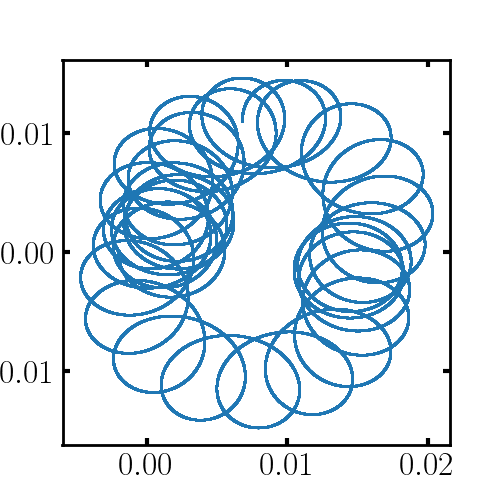

In [360]:
fig, axs = plt.subplots(figsize=(5,5))
#axs.scatter(e_int*np.cos(-th0_int-pom_int),e_int*np.sin(-th0_int-pom_int))
axs.scatter(np.sqrt(Phi_int)*np.cos(phi_int-ompval*sol.t),np.sqrt(Phi_int)*np.sin(phi_int-ompval*sol.t),s=1)

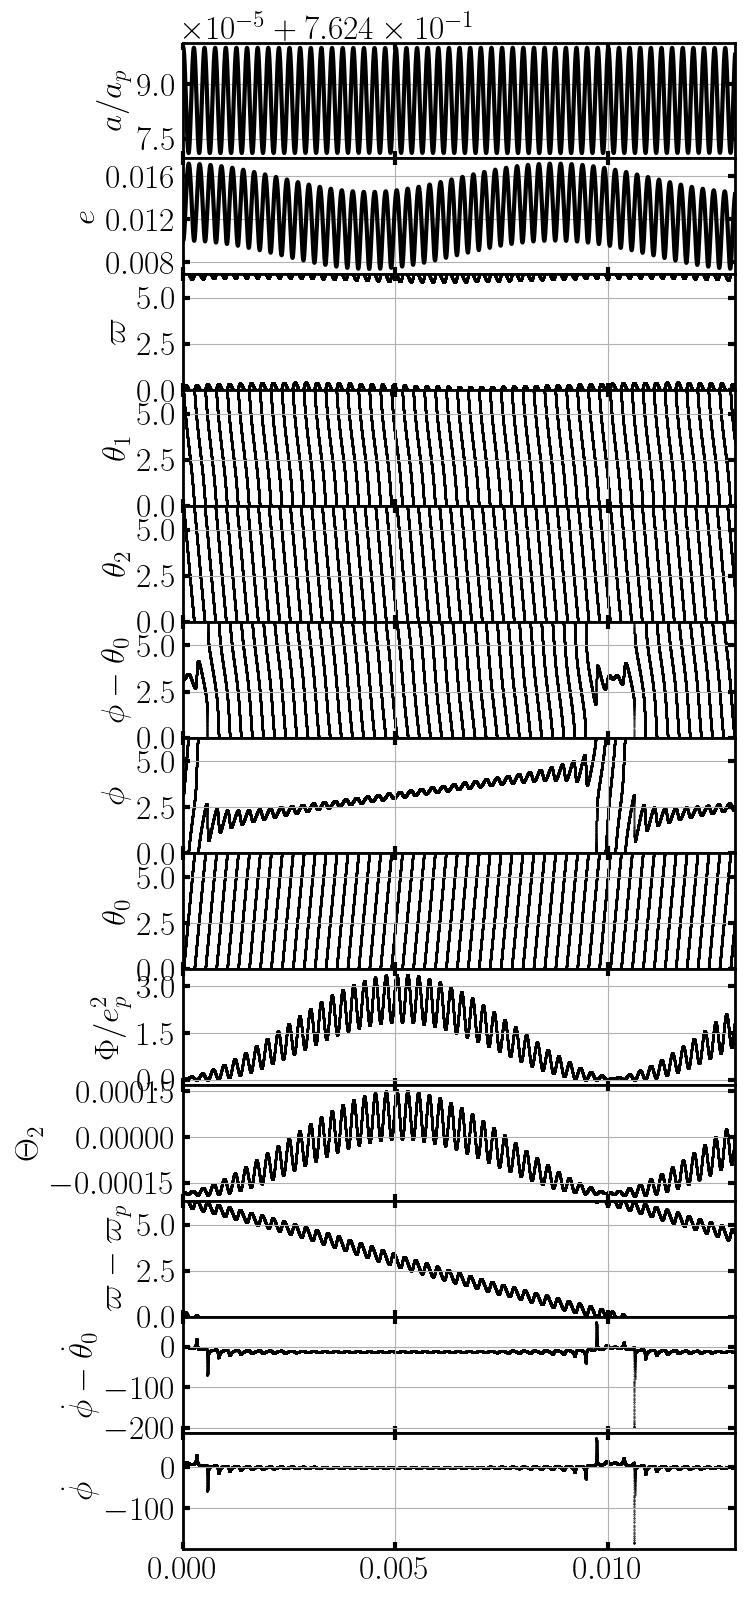

In [354]:
fig, ax = plot(sol,th0_int,a_int,e_int,pom_int,ompval,epval,mupval,2)